In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\Users\D\anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\D\anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\D\anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Preprocessing
# Loading MNIst dataset
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalization
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Train : Validation = 8 : 2 
features_train, features_valid, targets_train, targets_valid = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)

# Data's type to tensor
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long
featuresValid = torch.from_numpy(features_valid)
targetsValid = torch.from_numpy(targets_valid).type(torch.LongTensor) # data type is long
featuresTest = torch.from_numpy(X_test)
targetsTest = torch.from_numpy(Y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test TensorDataset
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
valid = torch.utils.data.TensorDataset(featuresValid,targetsValid)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# Hyper Parameters :batch_size, epoch and iteration
LR = 0.01
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [3]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,24,24)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,12,12)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,8,8)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,4,4)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [4]:
# Build the model
model = CNN_Model()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1,1,28,28)    

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


In [5]:
# Traning the Model 
def fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, vaild_loader):
    #history-like list for store loss & acc value
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    for epoch in range(num_epochs):
        #training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            # 1.Define variables
            train = Variable(images.view(input_shape))
            labels = Variable(labels)
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            outputs = model(train)
            # 4.Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, labels)
            # 5.Calculate gradients
            train_loss.backward()
            # 6.Update parameters
            optimizer.step()
            # 7.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 8.Total number of labels
            total_train += len(labels)
            # 9.Total correct predictions
            correct_train += (predicted == labels).float().sum()
        #10.store val_acc / epoch
        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        # 11.store loss / epoch
        training_loss.append(train_loss.data)

        #evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, labels in vaild_loader:
            # 1.Define variables
            test = Variable(images.view(input_shape))
            # 2.Forward propagation
            outputs = model(test)
            # 3.Calculate softmax and cross entropy loss
            val_loss = loss_func(outputs, labels)
            # 4.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 5.Total number of labels
            total_test += len(labels)
            # 6.Total correct predictions
            correct_test += (predicted == labels).float().sum()
        #6.store val_acc / epoch
        val_accuracy = 100 * correct_test / float(total_test)
        validation_accuracy.append(val_accuracy)
        # 11.store val_loss / epoch
        validation_loss.append(val_loss.data)
        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, val_loss.data, val_accuracy))
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [6]:
# Model fit
training_loss, training_accuracy, validation_loss, validation_accuracy = fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, valid_loader)

Train Epoch: 1/20 Traing_Loss: 0.08435747027397156 Traing_acc: 94.577080% Val_Loss: 0.08535727858543396 Val_accuracy: 98.033333%
Train Epoch: 2/20 Traing_Loss: 0.005861655343323946 Traing_acc: 98.093750% Val_Loss: 0.06649206578731537 Val_accuracy: 98.508331%
Train Epoch: 3/20 Traing_Loss: 0.06307712942361832 Traing_acc: 98.556252% Val_Loss: 0.024981549009680748 Val_accuracy: 98.158333%
Train Epoch: 4/20 Traing_Loss: 0.07864050567150116 Traing_acc: 98.612503% Val_Loss: 0.1689583659172058 Val_accuracy: 98.308334%
Train Epoch: 5/20 Traing_Loss: 0.06803229451179504 Traing_acc: 98.691666% Val_Loss: 0.25294584035873413 Val_accuracy: 97.741669%
Train Epoch: 6/20 Traing_Loss: 0.026453394442796707 Traing_acc: 98.704170% Val_Loss: 0.03626622259616852 Val_accuracy: 98.141670%
Train Epoch: 7/20 Traing_Loss: 0.09034063667058945 Traing_acc: 98.968750% Val_Loss: 0.07986323535442352 Val_accuracy: 98.175003%
Train Epoch: 8/20 Traing_Loss: 0.019723353907465935 Traing_acc: 98.872917% Val_Loss: 0.05375185

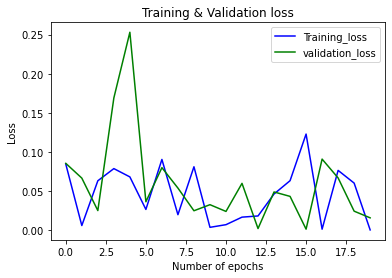

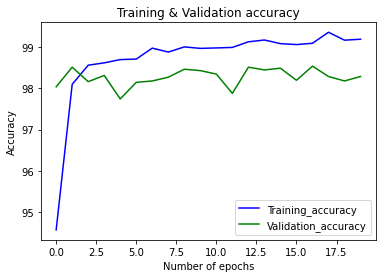

In [7]:
# visualization
plt.plot(range(num_epochs), training_loss, 'b-', label='Training_loss')
plt.plot(range(num_epochs), validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(num_epochs), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(num_epochs), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
# Predict testing data
def predict_model(test_loader):
    training_loss = []
    training_accuracy = []
    #evaluate model & store loss & acc / epoch
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        # 1.Define variables
        test = Variable(images.view(input_shape))
        # 2.Forward propagation
        outputs = model(test)
        # 3.Calculate softmax and cross entropy loss
        test_loss = loss_func(outputs, labels)
        # 4.Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        # 5.Total number of labels
        total_test += len(labels)
        # 6.Total correct predictions
        correct_test += (predicted == labels).float().sum()
    # Store test_acc
    test_accuracy = 100 * correct_test / float(total_test)
    return test_loss, test_accuracy

In [13]:
test_loss, test_accuracy = predict_model(test_loader)
print("Accuracy: ", test_accuracy)

Accuracy:  tensor(98.4900)
